In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import fitsio
import os
from desitarget.targetmask import desi_mask, obsconditions


In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

In [13]:
targetdata = fitsio.read("summary/fba_summary_mtl_dark_south_cut_C_tiles_cut_C.fits")

In [17]:
n = len(targetdata)
print(n)
ii = (targetdata['NUMOBS']==0)  & (targetdata['NAVAIL_TILE']>4)
jj = (targetdata['NAVAIL_TILE']>4)
print(np.count_nonzero(ii)/np.count_nonzero(jj))
jj = targetdata['RA']>180.0
targetdata['RA'][jj] = targetdata['RA'][jj]-360.0

1469571
0.3125562926734783


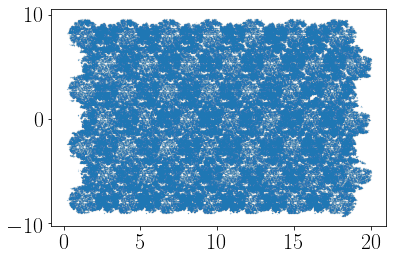

In [20]:
r = np.random.random(n)
ii = r<0.01
jj = (targetdata['NAVAIL_TILE']>4)
plt.scatter(targetdata['RA'][jj], targetdata['DEC'][jj], s=0.001)

In [21]:
theta = np.deg2rad(90.0 - targetdata['DEC'])
phi = np.deg2rad(targetdata['RA'])

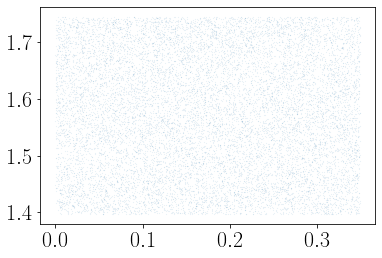

In [22]:
r = np.random.random(n)
ii = r<0.01
plt.scatter(phi[ii], theta[ii], s=0.001)

In [23]:
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

In [24]:
data = np.array([x,y,z])
data = data.T

In [25]:
np.shape(data)

(1469571, 3)

In [26]:
from sklearn.neighbors import NearestNeighbors

In [74]:
neighbors = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(data)

In [75]:
dist, ind = neighbors.kneighbors(data)

In [100]:
is_qso = (targetdata['DESI_TARGET']&desi_mask['QSO'])!=0
is_elg = (targetdata['DESI_TARGET']&desi_mask['ELG'])!=0
is_lrg = (targetdata['DESI_TARGET']&desi_mask['LRG'])!=0
is_science = is_qso|is_elg|is_lrg

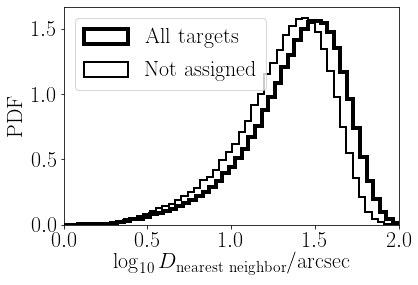

In [101]:
is_available = (targetdata['NAVAIL_TILE']>4)
never_observed = (targetdata['NUMOBS']==0)  & (targetdata['NAVAIL_TILE']>4)
_=plt.hist(np.log10(np.rad2deg(dist[is_available&is_science,1])*3600.0), 
           histtype='step', density=True, bins=100, label='All targets', linewidth=4, color='black')
_=plt.hist(np.log10(np.rad2deg(dist[never_observed&is_science,1])*3600.0), 
           histtype='step', density=True, bins=100, label='Not assigned', linewidth=2, color='black')
plt.xlabel("$\log_{10}  D_{\mathrm{nearest\ neighbor}} / \mathrm{arcsec}$")
plt.ylabel("PDF")
plt.legend(loc=2)

_ = plt.xticks(ticks=np.arange(0,2.2,0.5))
plt.xlim([0,2.0])
plt.savefig("DR8_neighbor_distro.pdf", bbox_inches='tight')

In [93]:
d_arcmin = np.rad2deg(dist)*60
in_patrol_radius = d_arcmin<1.0
n_in_patrol_radius = np.count_nonzero(in_patrol_radius, axis=1)

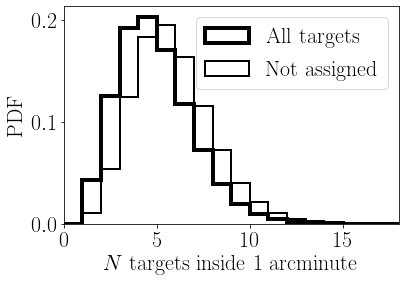

In [105]:
is_available = (targetdata['NAVAIL_TILE']>4)
never_observed = (targetdata['NUMOBS']==0)  & (targetdata['NAVAIL_TILE']>4)
_=plt.hist(n_in_patrol_radius[is_available&is_science], 
           histtype='step', density=True, bins=np.arange(30), label='All targets', linewidth=4, color='black')
_=plt.hist(n_in_patrol_radius[never_observed&is_science], 
           histtype='step', density=True, bins=np.arange(30), label='Not assigned', linewidth=2, color='black')
plt.xlabel("$N$ targets inside 1 arcminute")
plt.ylabel("PDF")
plt.legend(loc=1)

_ = plt.xticks(ticks=np.arange(0,30,5))
plt.xlim([0,18.0])
plt.savefig("DR8_n_in_radius_distro.pdf", bbox_inches='tight')